# Using Pyarrow
En este documento documentamos casos de uso empleando la librería pyarrow.

In [2]:
import pandas as pd
import pyarrow as pa
from pyarrow import csv
from utils.metadata import folders

# Cargamos cosas por si se usan después
table_bps = csv.read_csv(f"{folders['raw']}/01b_Sociodemograficos_fase4.txt",
                    parse_options=pa.csv.ParseOptions(delimiter='|'))

table_bps

FileNotFoundError: [Errno 2] Failed to open local file '/home/igutierrez/data/projects/sarscov2_variants//01b_Sociodemograficos_fase4.txt'. Detail: [errno 2] No such file or directory

## Remapeo
### pyarrow
#### (F) pa.compute.replace_with_mask()

Un mapeado de este tipo (usas un array con trues/falses) para substituir valores es fácil si los arrays son simples usando la función [pyarrow.compute.replace_with_mask](pyarrow.compute.replace_with_mask). Si son ChunkedArray, la máscara resultante también será un ChunkedArray, y ahí falla la función. 

#### pa.compute.if_else()

Una solución, válida para un mapeado pequeño, es usar if-else. básicamente se va sustituyendo en función de dos valores. Si no es uno, pongo otro. Si hay más de dos casos, se pueden encadenar.

In [ ]:
import pyarrow as pa
import pyarrow.compute as pc

# Creamos un ChunkedArray de prueba
chunk1 = pa.array([1, 0, 1, 1, 0])
chunk2 = pa.array([0, 1, 0, 0, 1])
chunked_array = pa.chunked_array([chunk1, chunk2])

print("Original ChunkedArray:")
print(chunked_array)

# Usamos if_else para recodificar. Si no es 1, pues metemos el otro valor
condition_1 = pc.equal(chunked_array, 1)
recoded_array = pc.if_else(condition_1, 8507, 8532)

print("\nRecoded ChunkedArray:")
print(recoded_array)

# Montamos una tabla para mostrarlo ordenado
result = pa.table(
    [chunked_array, recoded_array],
    names=['original_value', 'recoded_value'])

print("\nResult Table:")
print(result)

Que se traduce en la siguiente función para generalizar su uso.

In [ ]:
import pyarrow as pa
import pyarrow.compute as pc

# Creamos un ChunkedArray de prueba
def map_chunkedarray_if_else(
        input_field: pa.ChunkedArray,
        true_key: int,
        value_if_true: int,
        value_if_false: int) -> pa.ChunkedArray:
    """Given a ChunkedArray as input with binary values,
    ie. only has two possible values within, recode these
    original values to set of binary values.

    Parameters
    ----------
    input_field : pa.ChunkedArray
        input ChunkedArray to recode
    true_key : int
        original value to recode to 'value_if_true'
    value_if_true : int
        value to recode to if original value is 'true_key'
    value_if_false : int
        value to recode to if original value is not 'true_key'

    Returns
    -------
    pa.ChunkedArray
        resulting ChunkedArray
    """
    assert type(input_field) == pa.ChunkedArray
    assert type(true_key) == int
    assert type(value_if_true) == int
    assert type(value_if_false) == int

    # Use if_else to recode the values
    condition = pc.equal(chunked_array, true_key)
    recoded_array = pc.if_else(condition, value_if_true, value_if_false)

    # Combine the original and recoded arrays into a table
    return recoded_array


# Creamos un ChunkedArray de prueba
chunk1 = pa.array([1, 0, 1, 1, 0])
chunk2 = pa.array([0, 1, 0, 0, 1])
chunked_array = pa.chunked_array([chunk1, chunk2])
true_key = 1
value_if_true = 8507
value_if_false = 8532

result = map_chunkedarray_if_else(
    chunked_array, true_key, value_if_true, value_if_false)
print(result)

Esta función no es muy útil realmente, ya que sólo funciona en casos binarios, si no es el caso A, pues es el B. Se pueden añadir más if_else, pero no escala muy bien.

### (F) pa.compute.case_when()

Pyarrow también tiene una función llamada 'case_when()' que parece estar pensada para múltiples if-then. Se usa así:

    pc.case_when(cond, /, *cases, memory_pool=None)

cond debe ser un struct de booleans
cases puede ser una mezcla de valores escalares o arrays con:
    1- exactamente un hijo por cada condición
    2- exactamente un hijo más por cada condición, que seria el valor else
    
Parece que cond indica una serie de condiciones y luego facilitas una lista con qué
hacer en caso de que se cumpla cada condición.

Esa lista de condiciones debe ser un struct. ¿Qué es un [struct](https://arrow.apache.org/docs/python/generated/pyarrow.struct.html#pyarrow-struct)? Se supone que es un formato de datos anidado parametrizado por una secuencia ordenada de valores. Ahí te quedas.

In [ ]:
fields = [
    (True, pa.bool_()),
    (False, pa.bool_()),
]

struct_type = pa.struct(fields)
struct_type


### pa.compute.take()

Se puede intentar con la función take(). Esta función escoge los valores de un array en función de los numeros en otro. Es decir, el array original se toma como un array con posiciones, posiciones que se usan para escoger un número en otro array. Esto se puede usar para mapear.

Tiene la problemática de que hay que definir un array con tantas posiciones como el número más alto en nuestro array original. Teniendo en cuenta que los concept_id en una instancia OMOP-CDM puede tomar valores muy grandes, en el entorno de millones. Puede que no sea lo más eficiente en términos de memoria.

In [ ]:
import pyarrow as pa
import pyarrow.compute as pc

# Create a sample ChunkedArray
chunk1 = pa.array([1, 2, 3, 4, 5])
chunk2 = pa.array([0, 1, 0, 0, 1])
original_array = pa.chunked_array([chunk1, chunk2])

# Define the mapping array
mapping_array = pa.array([
    0,  # 1st position (will map to 0 in original array)
    0,  # 2nd position (will map to 1 in original array)
    200,  # 3rd position (will map to 2 in original array)
    300,  # 4th position (will map to 3 in original array)
    400,  # 5th position (will map to 4 in original array)
    500,  # 6th position (will map to 5 in original array)
    600,  # 7th position (will map to 6 in original array)
])

# Use pc.take to substitute values based on the mapping array
mapped_array = pc.take(mapping_array, original_array)

# Show the result
print(mapped_array)

### numpy

#### numpy.vectorize()

El método "clásico" sería pasar el array a un numpy.array y una vez allí vectorizar el diccionario de mapeo. El "problema" de este método es que el mapeado tiene que ser completo, si hay casos en el array que no estén contemplados en el mapeado, saltará un error.

In [ ]:
import numpy as np
# Prepare
original_array = pa.chunked_array([[1, 4, 3, 1, 2, 3, 0], [1, 2, 3, 0, 1]])
original_array = original_array.to_numpy()
print('original_array', original_array, original_array.dtype)
# Make the mapping and vectorize it
mapping_incomplete = {1: 8532, 0: 8507}
mapping_complete = {1: 23, 2: 34, 3: 36, 4: 45, 0: 0}
# Apply it and print results
result = np.vectorize(mapping_complete.get)(original_array)
print('resulting array', result, result.dtype)
# Apply non-complete mapping and get the error
result = np.vectorize(mapping_incomplete.get)(original_array)
print('resulting array', result, result.dtype)

#### numpy.where()

Otra opción, es usar np.where. Esto te permite ir dejando aquello que no esté cambiado. 

In [ ]:
# Prepare
original_array = pa.chunked_array([[1, 4, 3, 1, 2, 3, 0], [1, 2, 3, 0, 1]])
original_array = original_array.to_numpy()
print('original_array', original_array, original_array.dtype)
# Apply mapping
result = original_array.copy()
result = np.where(result == 1 , 8532, result)
result = np.where(result == 0 , 8507, result)
print('original_array', result, result.dtype)

#### Comparación

Vamos a replicar los métodos anteriores en funciones y a aplicarlos al mismo array para medir cuál es el más rápido.

In [2]:
import numpy as np
import pyarrow as pa
import pyarrow.compute as pc

def pa_if_else(original_array):
    # Usamos if_else para recodificar. Si no es 1, pues metemos el otro valor
    condition_1 = pc.equal(original_array, 1)
    return pc.if_else(condition_1, 8507, 8532)

def pa_take(original_array):
    # Define the mapping array
    mapping_array = pa.array([
        8507,  # 1st position (will map to 0 in original array)
        8532,  # 2nd position (will map to 1 in original array)
        101,  # 3rd position (will map to 2 in original array)
        102,  # 4th position (will map to 3 in original array)
        103,  # 5th position (will map to 4 in original array)
        104,  # 6th position (will map to 5 in original array)
        105,  # 7th position (will map to 6 in original array)
    ])
    # Use pc.take to substitute values based on the mapping array
    return pc.take(mapping_array, original_array)

def np_vectorize(original_array):
    original_array = original_array.to_numpy()
    # Make the mapping and vectorize it
    mapping_incomplete = {1: 8532, 0: 8507}
    mapping_complete = {1: 23, 2: 34, 3: 36, 4: 45, 0: 0}
    # Apply it and print results
    return np.vectorize(mapping_incomplete.get)(original_array)

def np_where(original_array):
    original_array = original_array.to_numpy()
    # Apply mapping
    result = original_array.copy()
    result = np.where(result == 1 , 8532, result)
    result = np.where(result == 0 , 8507, result)
    return result

Comparamos!

In [3]:
# Prepare chunk
chunk1 = pa.array([1, 0, 1, 1, 0])
chunk2 = pa.array([0, 1, 0, 0, 1])
original_array = pa.chunked_array([chunk1, chunk2])

# == == == == == == == == == == == == == == == == == 
# pyarrow if_else()
print('pyarrow if_else():')
try:
    %timeit pa_if_else(original_array)
except:
    print(' => Failed!')
# == == == == == == == == == == == == == == == == == 
# pyarrow take()
print('pyarrow take():')
try:
    %timeit pa_take(original_array)
except:
    print(' => Failed!')
# == == == == == == == == == == == == == == == == == 
# numpy vectorize()
print('numpy vectorize:')
try:
    %timeit np_vectorize(original_array)
except:
    print(' => Failed!')
# == == == == == == == == == == == == == == == == == 
# numpy where
print('numpy where:')
try:
    %timeit np_where(original_array)
except:
    print(' => Failed!')
# == == == == == == == == == == == == == == == == == 


pyarrow if_else():
31.8 μs ± 3.78 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
pyarrow take():
24.3 μs ± 2.4 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
numpy vectorize:
15.9 μs ± 834 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
numpy where:
8.44 μs ± 380 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Lo más rápido parece ser el np.where(). Esto funciona bien en casos binarios. Vamos a probar casos con un mapeo más complicado.

Redefinimos las funciones para que hagan uso de un mapping array externo.

In [4]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.compute as pc
import matplotlib.pyplot as plt
import seaborn as sns


def pa_take_map(original_array, mapping_array):
    # En este caso, el mapeado es directamente la lista
    mapping_tmp = [mapping_array[k] for k in mapping_array]
    # Use pc.take to substitute values based on the mapping array
    return pc.take(mapping_tmp, original_array)


def np_vectorize_map(original_array, mapping_array):
    # convert to numpy
    original_array = original_array.to_numpy()
    # Apply it and print results
    return np.vectorize(mapping_array.get)(original_array)


def np_where_map(original_array, mapping_array):
    # Convert to numpy
    original_array = original_array.to_numpy()
    # Apply mapping
    result = original_array.copy()
    for key in mapping_array:
        result = np.where(result == key, mapping_array[key], result)
    return result

Rehacemos las pruebas

In [52]:
import time

# Parametros
chunk_number = 10
chunk_size = 1000
mapping_size = 1000


def test_func(func, original_array, mapping, n_tries=5):
    print(f" - Testing {func.__name__} ...")
    try:
        elapsed_time = []
        for n in range(n_tries):
            t_start = time.time_ns()
            func(original_array, mapping)
            elapsed_time.append(time.time_ns() - t_start)
        return np.mean(elapsed_time)
    except:
        print(f'  => {func.__name__} failed!')


def test_times(chunk_number, chunk_size, mapping_size):
    # == Generamos el mapping ==
    # Suponemos un caso con 1000 valores distintos. Como están en orden, esto me asegura que pa.compute.take() puede funcionar.
    keys = np.arange(mapping_size)
    # Vamos a emparejar estos valores con otros tantos por encima. Nos aseguramos de que no haya reemplazamiento para que el emparejamiento sea unívoco.
    values = np.random.choice(keys+mapping_size*10, size=mapping_size, replace=False)
    # Generamos un diccionario relacionando unos con otros.
    mapping = dict(zip(keys, values))

    # == Generación de datos ==
    # Vamos a generar un ChunkedArray con 100 valores
    np.random.seed(42)
    original_array = []
    for i in range(chunk_number):
        original_array.append(np.random.choice(
            keys, size=chunk_size, replace=True))
    original_array = pa.chunked_array(original_array)
    original_array

    print(f"> Testing for {chunk_number} chunks of {chunk_size} elements using a {mapping_size}-element mapping:")
    result = []
    for func in [pa_take_map, np_vectorize_map, np_where_map]:
        elapsed_time = test_func(func, original_array, mapping)
        result.append({
            'chunk_number': chunk_number, 'chunk_size': chunk_size, 'mapping_size': mapping_size,
            'func': func.__name__, 'time (us)': np.round(elapsed_time/1e9, 4)})
    # == == == == == == == == == == == == == == == == ==
    return result

In [53]:
tiempos = []
for chunk_n in [100,1000,10000]:
    result = test_times(chunk_n,100,100)
    tiempos += result
for chunk_s in [100,1000,10000]:
    result = test_times(100,chunk_s,100)
    tiempos += result
for mapp_s in [100,1000,10000,100000]:
    result = test_times(100,100,mapp_s)
    tiempos += result
tiempos += result
df_general = pd.DataFrame(tiempos)
df_general

> Testing for 100 chunks of 100 elements using a 100-element mapping:
 - Testing pa_take_map ...
 - Testing np_vectorize_map ...
 - Testing np_where_map ...
> Testing for 1000 chunks of 100 elements using a 100-element mapping:
 - Testing pa_take_map ...
 - Testing np_vectorize_map ...
 - Testing np_where_map ...
> Testing for 10000 chunks of 100 elements using a 100-element mapping:
 - Testing pa_take_map ...
 - Testing np_vectorize_map ...
 - Testing np_where_map ...
> Testing for 100 chunks of 100 elements using a 100-element mapping:
 - Testing pa_take_map ...
 - Testing np_vectorize_map ...
 - Testing np_where_map ...
> Testing for 100 chunks of 1000 elements using a 100-element mapping:
 - Testing pa_take_map ...
 - Testing np_vectorize_map ...
 - Testing np_where_map ...
> Testing for 100 chunks of 10000 elements using a 100-element mapping:
 - Testing pa_take_map ...
 - Testing np_vectorize_map ...
 - Testing np_where_map ...
> Testing for 100 chunks of 100 elements using a 100

,chunk_number,chunk_size,mapping_size,func,time (us)
0,100,100,100,pa_take_map,0.0006
1,100,100,100,np_vectorize_map,0.0021
2,100,100,100,np_where_map,0.0016
3,1000,100,100,pa_take_map,0.0039
4,1000,100,100,np_vectorize_map,0.0115
5,1000,100,100,np_where_map,0.0107
6,10000,100,100,pa_take_map,0.0240
7,10000,100,100,np_vectorize_map,0.1396
8,10000,100,100,np_where_map,0.1602
9,100,100,100,pa_take_map,0.0006


    chunk_number  chunk_size  mapping_size         func  time (us)
0            100         100           100  pa_take_map     0.0006
3           1000         100           100  pa_take_map     0.0039
6          10000         100           100  pa_take_map     0.0240
9            100         100           100  pa_take_map     0.0006
18           100         100           100  pa_take_map     0.0002
    chunk_number  chunk_size  mapping_size              func  time (us)
1            100         100           100  np_vectorize_map     0.0021
4           1000         100           100  np_vectorize_map     0.0115
7          10000         100           100  np_vectorize_map     0.1396
10           100         100           100  np_vectorize_map     0.0024
19           100         100           100  np_vectorize_map     0.0009
    chunk_number  chunk_size  mapping_size          func  time (us)
2            100         100           100  np_where_map     0.0016
5           1000         100  

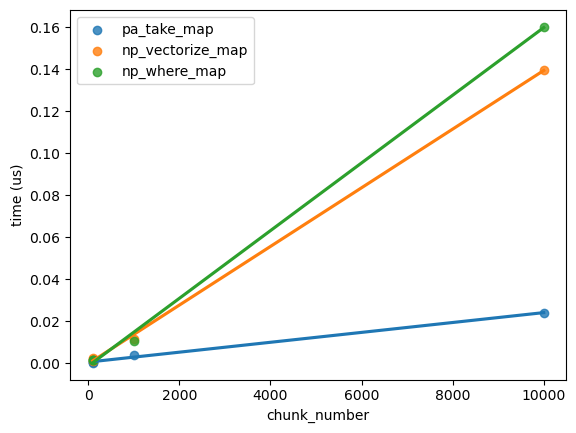

    chunk_number  chunk_size  mapping_size         func  time (us)
0            100         100           100  pa_take_map     0.0006
9            100         100           100  pa_take_map     0.0006
12           100        1000           100  pa_take_map     0.0004
15           100       10000           100  pa_take_map     0.0025
18           100         100           100  pa_take_map     0.0002
    chunk_number  chunk_size  mapping_size              func  time (us)
1            100         100           100  np_vectorize_map     0.0021
10           100         100           100  np_vectorize_map     0.0024
13           100        1000           100  np_vectorize_map     0.0109
16           100       10000           100  np_vectorize_map     0.1167
19           100         100           100  np_vectorize_map     0.0009
    chunk_number  chunk_size  mapping_size          func  time (us)
2            100         100           100  np_where_map     0.0016
11           100         100  

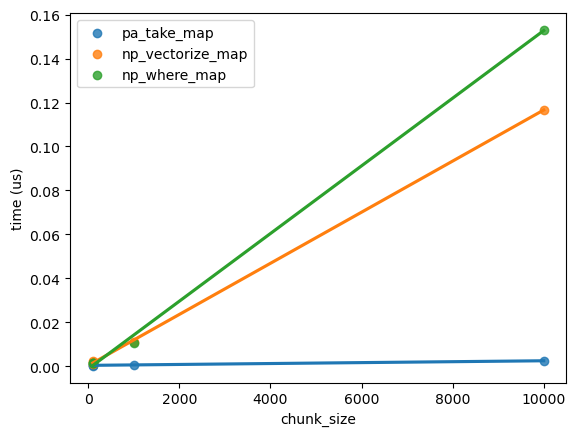

In [57]:
# Figura con todas
plt.figure()
for func in ['pa_take_map', 'np_vectorize_map', 'np_where_map']:
    idx = (df_general['func']==func) & (df_general['chunk_size']==100) & (df_general['mapping_size']==100)
    print(df_general.loc[idx])
    sns.regplot(df_general.loc[idx] , x='chunk_number',y='time (us)', label=func,ci=None)
plt.legend()
plt.show()
# Figura con todas
plt.figure()
for func in ['pa_take_map', 'np_vectorize_map', 'np_where_map']:
    idx = (df_general['func']==func) & (df_general['chunk_number']==100) & (df_general['mapping_size']==100)
    print(df_general.loc[idx])
    sns.regplot(df_general.loc[idx] , x='chunk_size',y='time (us)', label=func,ci=None)
plt.legend()
plt.show()

Hay un incremento del tiempo de procesamiento con el número de chunks, lo cual era previsible. 
Más o menos se incrementa un orden de magnitud en el tiempo por cada orden de magnitud incrementado en el chunk_size.
Ocurre lo mismo cuando aumentamos chunk_size.

np.where es el que más tarda, seguido de np.vectorize y finalmente pc.take(). Parece además que tanto np.vectorize() como pc.take() sufren menos si los chunks son más 
grandes que si hacemos más chunks.

    chunk_number  chunk_size  mapping_size         func  time (us)
0            100         100           100  pa_take_map     0.0006
9            100         100           100  pa_take_map     0.0006
18           100         100           100  pa_take_map     0.0002
21           100         100          1000  pa_take_map     0.0005
24           100         100         10000  pa_take_map     0.0017
27           100         100        100000  pa_take_map     0.0226
30           100         100        100000  pa_take_map     0.0226
    chunk_number  chunk_size  mapping_size              func  time (us)
1            100         100           100  np_vectorize_map     0.0021
10           100         100           100  np_vectorize_map     0.0024
19           100         100           100  np_vectorize_map     0.0009
22           100         100          1000  np_vectorize_map     0.0013
25           100         100         10000  np_vectorize_map     0.0010
28           100         100    

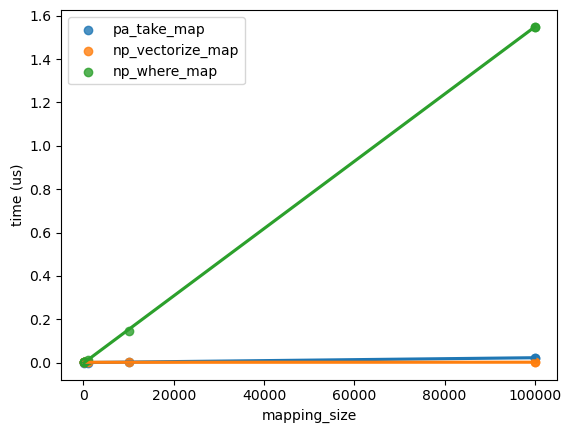

In [59]:
# Figura con todas
plt.figure()
for func in ['pa_take_map', 'np_vectorize_map', 'np_where_map']:
    idx = (df_general['func']==func) & (df_general['chunk_number']==100) & (df_general['chunk_size']==100)
    print(df_general.loc[idx])
    sns.regplot(df_general.loc[idx] , x='mapping_size',y='time (us)', label=func,ci=None)
plt.legend()
plt.show()

Cuando aumentamos eltamaño del mapeo, el único que sufre realmente es np.where(). Las otras dos, o bien suben el tiempo más lentamente, o bien llegan a un tope y listo.

### Resumen
La que peor escala es np.where(). A medida que aumenan el número de chunks el tiempo aumenta linealmente. Sería mejor evitarla en general.

La que mejor funciona en general es pa.compute.take(). El problema es definir bien ese mapeo sin que haya errores.

La más sencilla de usar y que podría funcionar bien en la mayoría de los casos es np.vectorize().

Si es posible, aumentar primero el tamaño de los chunks antes que su número.

El tamaño del mapa no es muy importante a menos que se use np.where().

## Jugando con pyarrow

In [27]:
import pyarrow.compute as pc

# Parece que pyarrow hace copias al renombrar variables.
# => No hay problemas con modificar variables de las que
#    dependen otras variables

# Sacamos el array que transformaremos
inpField = table_bps['COD_NUHSA']
print('inpField',inpField[:5])
# Guardamos ya el _source_value
person_source_value = inpField
print('person_source_value',person_source_value[:5])
# Si hay que hacer transformaciones, hacerlas aquí
inpField = pc.utf8_slice_codeunits(inpField,2)
inpField = inpField.cast(pa.int32())
print('inpField',inpField[:5])
print('person_source_value',person_source_value[:5])

# ==> inpField se ha modificado mientras que person_source_value sigue como estaba 
#     cuando se le asignó el valor

NameError: name 'table_bps' is not defined

In [ ]:
# Leer muchos archivos

import pyarrow as pa
import pyarrow.csv

column_names = {}
for f in file_list[0:]:
    print(f)
    if 'Farmacia' in f.split('/'):
        parse_options = pa.csv.ParseOptions(delimiter=';')
        read_options = pa.csv.ReadOptions(block_size=5000,skip_rows=5)
    else:
        parse_options = pa.csv.ParseOptions(delimiter='|')
        read_options = pa.csv.ReadOptions(block_size=5000,skip_rows=0)
        
    with pyarrow.csv.open_csv(f,
                              parse_options=parse_options,
                              read_options=read_options) as reader:
        for next_chunk in reader:
            if f not in column_names.keys():
                column_names[f] = next_chunk.column_names
            else:
                break

column_names

## Comparando con nans
Tengo casos en los que voy a ir comparando fechas y calculando los días entre ellas. Qué pasa si tengo nans?

In [3]:
import pyarrow as pa
import pyarrow.compute as pc

a = pa.array([8,None],pa.int64())
b = pa.array([9,9],pa.int64())
print(pc.greater(b,a))

[
  true,
  null
]


<pyarrow.BooleanScalar: True>

Si comparo dos vectores que incluyen un nan. La función me devuelve nan allá donde lo haya.

In [5]:
pc.all(pc.greater(b,a))

<pyarrow.BooleanScalar: True>

Peero, si tengo un arrays de pyarrow.BooleanScalar y quiero ver si todos son True, **pyarrow ignorará los nan/null y sólo mirará si el resto cumplen la condición**.

Si calculo los días...


In [9]:
from datetime import datetime

a = pa.scalar(datetime(2012, 1, 1), type=pa.date64())
b = pa.scalar(datetime(2012, 1, 2), type=pa.date64())
c = pa.scalar(datetime(2012, 1, 3), type=pa.date64())

A = pa.array([a,None],pa.date64())
B = pa.array([b,c],pa.date64())

pc.days_between(A,B)

[
  1,
  null
]

Me devuelve null.